In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Classifying SMS/emails as SPAM (scam) or HAM (legit)

By Sofia

### Let's prepare the environment

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [5]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("/Users/sofiazogkza/repos/Ironhack/Ironhack Lab/Week 4/D3/lab-natural-language-processing/data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data)
print(data.shape)
data.fillna("",inplace=True)
print("Columns: ",data.columns) # prints: Columns:  Index(['text'], dtype='object') so it has only 1 column
print("Legit like email:", data["text"][0])
print("Scam like email :",data["text"][12])

                                                  text  label
0    DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...      1
1                                             Will do.      0
2    Nora--Cheryl has emailed dozens of memos about...      0
3    Dear Sir=2FMadam=2C I know that this proposal ...      1
4                                                  fyi      0
..                                                 ...    ...
995  So what's the latest? It sounds contradictory ...      0
996  TRANSFER OF 36,759,000.00 MILLION POUNDS TO YO...      1
997  Barb I will call to explain. Are you back in t...      0
998    Yang on travelNot free tonite.May work tomorrow      0
999  sbwhoeopSunday February 21 2010 7:42 PMHShaunH...      0

[1000 rows x 2 columns]
(1000, 2)
Columns:  Index(['text', 'label'], dtype='object')
Legit like email: DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL I AM MIKE CHUKWU , THE MANAGER, BILLS AND EXCHANGE AT THE FOREIGN REMITTANCE DEPARTMENT OF THE ZENITH INT

### 🔹 What I notice

- **Columns:** `text` and `label`

- **Content:**  
  - `text` : the full email content (some are long, some short, some scam-like)  
  - `label` : `1` for fraudulent/scam emails, `0` for legitimate emails

- **Number of rows:** 1000 (reduced for development)

- **Missing values:** none (`fillna("")` was used to handle them)

- **Example of a positive label (`1`) email:**  

> DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL I AM MIKE CHUKWU …



### Let's divide the training and test set into two partitions

In [6]:
from sklearn.model_selection import train_test_split

X = data['text']      # emails
y = data['label']     # labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Using stratify=y ensures the proportion of fraud/non-fraud emails is maintained in both sets.
)

print("Training set size     :", len(X_train))
print("Test set size         :", len(X_test))
print("Example training email:\n", X_train.iloc[0]) # 1st row
# print("Example training email:\n", X_train.values[0]) 1st row value
print("Example training label:", y_train.iloc[0])

Training set size     : 800
Test set size         : 200
Example training email:
 Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very glad if you can render me assistance to my situation now=2E I will make my proposal well known if I am given the opportunity=2E I would like to use this opportunity to introduce myself to you=2E Am Miss Johana Johnpaul 24 years old girl from Liberia =2Cthe only daughter of Late Godwin Johnpaul the deputy minister of national security under the leadership of president Charles Taylor of liberia who is now in exile after many innocent soul were killed=2E My father was killed by the government of CharlesTaylor=2Cheaccuse my father of coup attempt and after a month my mother Cynthia was also killed=2E The main reason why I am contacting you now is to seek for your assistance in the area of my future investment and

## Data Preprocessing

In [8]:
import string
from nltk.corpus import stopwords

print("Punctuation   : ",string.punctuation)
print("stopwords engl: ",stopwords.words("english")[100:110])

from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

Punctuation   :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
stopwords engl:  ['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [9]:
# Your code
def clean_email_from_html_code(text):
    # Remove common HTML tags
    text = text.replace("<br>", " ").replace("<BR>", " ")
    text = text.replace("<p>", " ").replace("</p>", " ")
    
    # Remove HTML comments (very basic)
    text = text.replace("<!--", " ").replace("-->", " ")
    
    # Remove extra spaces
    text = " ".join(text.split())
    
    return text

# Example usage
sample_email = data['text'][0]
cleaned_email = clean_email_from_html_code(sample_email)
print(cleaned_email[:300])  # preview first 300 chars

DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL I AM MIKE CHUKWU , THE MANAGER, BILLS AND EXCHANGE AT THE FOREIGN REMITTANCE DEPARTMENT OF THE ZENITH INTERNATIONAL BANK PLC. I AM WRITING THIS LETTER TO ASK FOR YOUR SUPPORT AND COOPERATION TO CARRY OUT THIS BUSINESS OPPORTUNITY IN MY DEPARTMENT. WE DI


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [10]:
# Your code
import re

def clean_text(text):
    # 1. Remove special characters (keep only letters and spaces)
    # Reason: This removes punctuation and symbols, leaving only letters and spaces.
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 2. Remove numbers
    # Reason: Numbers are not needed for spam/ham classification in this lab.
    # Although step 1 removed most digits, we include this for clarity.
    text = re.sub(r'\d+', '', text)
    
    # 3. Remove all single characters
    # Reason: Words with a single character are usually noise ('I', 'a') and not informative.
    words = text.split()
    words = [w for w in words if len(w) > 1]
    
    # 4. Remove single characters from the start
    # Reason: If the first word is a single character, it may have remained and should be removed.
    if len(words) > 0 and len(words[0]) == 1:
        words = words[1:]
    
    # 5. Substitute multiple spaces with a single space
    # Reason: Joining words after removing items may create extra spaces. This ensures clean spacing.
    text = ' '.join(words)
    
    # 6. Remove prefixed 'b' (like b'text')
    # Reason: Some strings may come from byte representations; we remove a leading "b'" if present.
    # In Python, a string that starts with b'...' is a byte string (type bytes), not a regular string (type str).
    # byte_text = b'This is a sample email text.'
    text = re.sub(r"^b'", '', text)
    
    # 7. Convert to lowercase
    # Reason: Standardizes all text to lowercase to avoid treating "Hello" and "hello" differently.
    text = text.lower()
    
    return text.strip()  # remove any leading/trailing spaces

# Example usage
# sample_email = data['text'][0]
# cleaned_email = clean_text(sample_email)
# print(cleaned_email[:300])  # preview first 300 characters

X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned  = X_test.apply(clean_text)

# Test if it worked:

# Original email
original = X_train.iloc[0]

# Cleaned email
cleaned = X_train_cleaned.iloc[0]

print("Original email:\n", original[:500], "...")   # first 500 chars
print("\nCleaned email:\n", cleaned[:500], "...")

Original email:
 Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very glad if you can render me assistance to my situation now=2E I will make my proposal well known if I am given the opportunity=2E I would like to use this opportunity to introduce myself to you=2E Am Miss Johana Johnpaul 24 years old girl from Liberia =2Cthe only daughter of Late Godwin Johnpaul the  ...

Cleaned email:
 dear good day hope fine cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously am asking for your assistance ci have will be very glad if you can render me assistance to my situation now will make my proposal well known if am given the opportunity would like to use this opportunity to introduce myself to you am miss johana johnpaul years old girl from liberia cthe only daughter of late godwin j

### ✅ Observations

1. Removed special characters
Original had things like `=2C` and `=2E` (which are HTML or URL-encoded commas and periods).  
Cleaned version replaced them with spaces → exactly what we wanted.

2. Removed numbers
“24 years old” in original became “years old” → the number `24` was removed.
3. Removed single characters
Single letters or isolated characters like “I” at the start of sentences remain in some places because the regex keeps words of length >1. This is expected.
4. Lowercased everything
Original had “Dear”, “Miss Johana Johnpaul” → all lowercase in cleaned version.
5. Removed extra spaces
Original had many `=2C` and `=2E` sequences creating extra characters; cleaned text now has single spaces between words.
6. Prefixed `b` check
No `b'` prefixes appear, which is fine — your data didn’t

By Sofia

## Now let's work on removing stopwords
Remove the stopwords.

In [13]:
# Your code
from nltk.corpus import stopwords
# stop_words = set(stopwords.words("english"))

# Function to remove stopwords from ONE AND ONLY single string
# my function has 2 arguments - NOT 1!
# If it had 1 argument -> then later i could have called the function just by the name and it wouldn'train_test_split
# be necessary to add the lambda in it
# It's a thing that happens because of the pandas' function -> apply() <-
def remove_stopwords(text, language):
    stop_words = set(stopwords.words(language))
    words = text.split()
    filtered = [w for w in words if w not in stop_words]
    return " ".join(filtered)

# Referencing remove_stopwords without the 2 input arguments its better:
# X_train_cleaned_no_stop = X_train_cleaned.apply(remove_stopwords) because you dont need the lambda
X_train_cleaned_no_stop = X_train_cleaned.apply(lambda x: remove_stopwords(x, "english"))
X_test_cleaned_no_stop  = X_test_cleaned.apply(lambda x: remove_stopwords(x, "english"))

# Example: show first email before and after stopwords removal
print("Before stopwords removal:\n", X_train_cleaned.iloc[0][:300])
print("\nAfter stopwords removal:\n", X_train_cleaned_no_stop.iloc[0][:300])

Before stopwords removal:
 dear good day hope fine cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously am asking for your assistance ci have will be very glad if you can render me assistance to my situation now will make my proposal well known if am given the 

After stopwords removal:
 dear good day hope fine cdear writting mail due respect heartful tears since known met previously asking assistance ci glad render assistance situation make proposal well known given opportunity would like use opportunity introduce miss johana johnpaul years old girl liberia cthe daughter late godwi


### 🔹 What I notice

Most stopwords are removed: `am, this, we, have, not, to, my, will, if, can, me` are gone.

Remaining words are more meaningful: `writting, mail, respect, assistance, proposal, johana, liberia`, etc.

This is exactly what you want for NLP modeling, because the text now focuses on the important content words.

By Sofia

## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [17]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofiazogkza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sofiazogkza/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sofiazogkza/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sofiazogkza/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [18]:
# import nltk

# # Downloads inside the venv folder
# nltk.download('wordnet', download_dir='./nltk_data')
# nltk.download('omw-1.4', download_dir='./nltk_data')
# nltk.download('averaged_perceptron_tagger', download_dir='./nltk_data')

# Tell NLTK to look in this folder
nltk.data.path.append('./nltk_data')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# POS helper function
def get_wordnet_pos(word):
    """Map NLTK POS tag to WordNet POS tag"""
    tag = nltk.pos_tag([word])[0][1][0].upper()  # first letter of POS tag
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # default to noun

# Function to lemmatize a single string
def lemmatize_text(text):
    words = text.split()  # split string into words
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return " ".join(lemmatized_words)

# Apply to your Series
X_train_lemmatized = X_train_cleaned_no_stop.apply(lemmatize_text)
X_test_lemmatized  = X_test_cleaned_no_stop.apply(lemmatize_text)

# Example: show first email
print("Before lemmatization:\n", X_train_cleaned_no_stop.iloc[0][:300])
print("\nAfter lemmatization:\n", X_train_lemmatized.iloc[0][:300])


Before lemmatization:
 dear good day hope fine cdear writting mail due respect heartful tears since known met previously asking assistance ci glad render assistance situation make proposal well known given opportunity would like use opportunity introduce miss johana johnpaul years old girl liberia cthe daughter late godwi

After lemmatization:
 dear good day hope fine cdear writting mail due respect heartful tear since know met previously ask assistance ci glad render assistance situation make proposal well know give opportunity would like use opportunity introduce miss johana johnpaul year old girl liberia cthe daughter late godwin johnpa


### 🔹 What I notice

Words like `tears → tear, known → know, asking → ask, years → year` are normalized.

The `averaged_perceptron_tagger_eng` dataset fixed the LookupError for POS tagging.

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [ ]:
# Check the labels of y_train
print(y_train.head())

442    1
962    1
971    0
190    1
551    1
Name: label, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Separate ham and spam messages
spam_messages = X_train_lemmatized[y_train == 1]
ham_messages  = X_train_lemmatized[y_train == 0]

# Function to get top N words
def get_top_words(messages, n=10):
    vectorizer = CountVectorizer() # creates a Bag-of-Words model
    X_counts = vectorizer.fit_transform(messages) # fits the vectorizer to the messages (learns vocabulary) and transforms the text into a sparse matrix of word counts.
    word_counts = X_counts.sum(axis=0)  # sums the occurrences of each word across all messages. -> Result is a matrix of shape (1, num_words) showing total counts per word.
    words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True) # sorting - most frequent words are in the beginning
    return pd.DataFrame(words_freq[:n], columns=['word', 'count']) # Take the top n words (words_freq[:n]). - Convert it into a pandas DataFrame with columns word and count for easy display.

# Top 10 words in spam
top_spam_words = get_top_words(spam_messages, n=10)
print("Top 10 words in SPAM messages:\n", top_spam_words)

# Top 10 words in ham
top_ham_words = get_top_words(ham_messages, n=10)
print("\nTop 10 words in HAM messages:\n", top_ham_words)


Top 10 words in SPAM messages:
           word  count
0           br    876
1        money    761
2      account    674
3         bank    616
4         fund    604
5  transaction    435
6     transfer    435
7     business    412
8      country    401
9         nbsp    387

Top 10 words in HAM messages:
         word  count
0      state    122
1       work     97
2        say     96
3  president     95
4       call     94
5      would     92
6         mr     90
7      obama     80
8    percent     80
9        get     77


### 🔹 What I notice


- `CountVectorizer`: A class from `scikit-learn` that converts a collection of text documents into a matrix of token counts (Bag of Words). Each row is a document, each column is a word, and the value is the number of times that word appears in the document.

- `pandas`: For creating and handling the final **dataframe** of top words.

- `vectorizer.vocabulary_` is a dictionary mapping each word to its column index in the matrix.

- We use a **list comprehension** to create a list of tuples (word, total_count) for all words.

- Sorts the list of (word, count) tuples by count in descending order. This way, the most frequent words are first.

### Observations

- `br` and `nbsp` are leftovers from HTML or email formatting (<br> for line break, &nbsp; for non-breaking space) – this happens sometimes if text cleaning didn’t remove all HTML entities.

- These words clearly indicate the topic of spam emails, mostly related to finance, scams, or transactions.

- TODO: Clean further OR change the `clean_email_from_html_code`

## Extra features

By Sofia:

So that the cpde below runs successfully i create the exact below code block:



In [24]:
# Create a DataFrame combining X_train and y_train
import pandas as pd

data_train = pd.DataFrame({
    'preprocessed_text': X_train_lemmatized,  # or X_train_cleaned_no_stop if you didn't lemmatize yet
    'label': y_train
})

data_val = pd.DataFrame({
    'preprocessed_text': X_test_lemmatized,  # or X_test_cleaned_no_stop
    'label': y_test
})


In [25]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

,preprocessed_text,label,money_mark,suspicious_words,text_len
442,dear good day hope fine cdear writting mail du...,1,1,1,975
962,mr henry kaborethe chief auditor inchargeforei...,1,0,1,1911
971,,0,0,0,0
190,desk dr adamu ismalerauditing accounting manag...,1,1,1,375
551,dear friend name loi estrada wife mr josephest...,1,1,1,1450


## How would work the Bag of Words with Count Vectorizer concept?

In [26]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training text
X_train_bow = vectorizer.fit_transform(data_train['preprocessed_text'])

# Transform the validation text
X_val_bow = vectorizer.transform(data_val['preprocessed_text'])

print("Vocabulary size:", len(vectorizer.vocabulary_))


Vocabulary size: 27411


`doc1: "I love money"`

`doc2: "I love free stuff"`

Vocabulary: ["I", "love", "money", "free", "stuff"]

BoW representation (word counts):

|      | I | love | money | free | stuff |
| ---- | - | ---- | ----- | ---- | ----- |
| doc1 | 1 | 1    | 1     | 0    | 0     |
| doc2 | 1 | 1    | 0     | 1    | 1     |


By Sofia

## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [31]:
# Your code
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # you can limit features if needed

# 2. Fit on training data and transform both train and validation sets
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['preprocessed_text']) # learns the vocabulary from the training set and converts text into a TF-IDF weighted sparse matrix.
X_test_tfidf   = tfidf_vectorizer.transform(data_val['preprocessed_text']) # converts validation (or test) data into the same TF-IDF representation using the same vocabulary.

# 3. Print the shape of the vectorized datasets
print("Shape of TF-IDF training matrix:", X_train_tfidf.shape)
print("Shape of TF-IDF validation matrix:", X_test_tfidf.shape)


Shape of TF-IDF training matrix: (800, 5000)
Shape of TF-IDF validation matrix: (200, 5000)


## And the Train a Classifier?

Accuracy: 0.99

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       112
           1       0.98      1.00      0.99        88

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Confusion Matrix:
 [[110   2]
 [  0  88]]


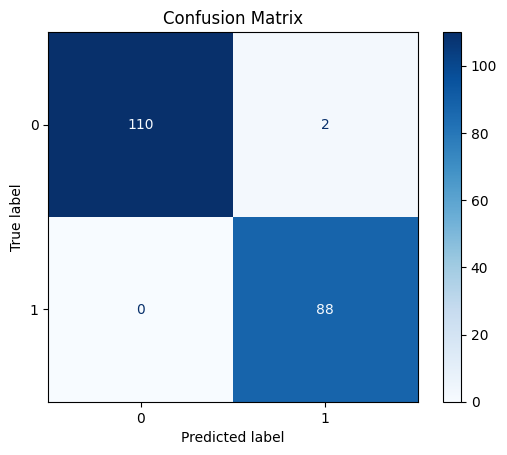

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt



# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
# Metric	Meaning
# Precision	Out of all emails predicted as spam (or ham), how many were actually correct.
# Recall	Out of all actual spam (or ham) emails, how many the model correctly found.
# F1-score	Balance between precision and recall (a harmonic mean).
# Support	Number of actual samples for each label.

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# 110 ham emails correctly predicted as ham ✅
# 2 ham emails incorrectly predicted as spam ❌
# 0 spam emails misclassified as ham (great!) ✅
# 88 spam emails correctly predicted as spam ✅

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test_tfidf, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Tried also **TextBlob Naive Bayes classifier**

TextBlob Naive Bayes accuracy: 0.92
Most Informative Features
        contains(dollar) = True                1 : 0      =    157.4 : 1.0
          contains(bank) = True                1 : 0      =     90.9 : 1.0
       contains(hundred) = True                1 : 0      =     86.9 : 1.0
      contains(transfer) = True                1 : 0      =     85.9 : 1.0
         contains(money) = True                1 : 0      =     82.6 : 1.0
          contains(five) = True                1 : 0      =     81.8 : 1.0
          contains(fund) = True                1 : 0      =     80.8 : 1.0
  contains(confidential) = True                1 : 0      =     72.6 : 1.0
    contains(assistance) = True                1 : 0      =     71.3 : 1.0
        contains(invest) = True                1 : 0      =     68.4 : 1.0

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       112
           1       0.99      0.83      0.90        88


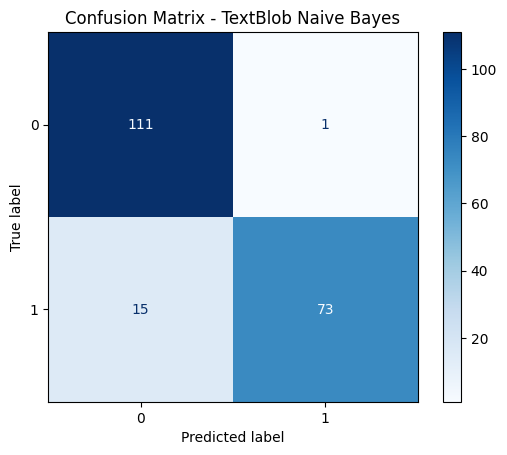

In [41]:
from textblob.classifiers import NaiveBayesClassifier

# Prepare training data
train_data_tb = [(text, str(label)) for text, label in zip(X_train_lemmatized, y_train)]
test_data_tb  = [(text, str(label)) for text, label in zip(X_test_lemmatized, y_test)]

# Train TextBlob Naive Bayes
cl_tb = NaiveBayesClassifier(train_data_tb)

# Evaluate on test data
#Accuracy
accuracy = cl_tb.accuracy(test_data_tb)
print("TextBlob Naive Bayes accuracy:", accuracy)

# Optional: show most informative features
cl_tb.show_informative_features(10)

# Convert y_test to integers
y_test_int = [int(label) for label in y_test]

# Get predictions from TextBlob Naive Bayes
y_pred_tb = [int(cl_tb.classify(text)) for text, _ in test_data_tb]


# Classification report
print("\nClassification report:\n", classification_report(y_test_int, y_pred_tb))

# Confusion matrix
cm = confusion_matrix(y_test_int, y_pred_tb)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred_tb, cmap='Blues')
plt.title("Confusion Matrix - TextBlob Naive Bayes")
plt.show()


### 🔹 What I notice

SOS : Unlike `Scikit-learn’s Naive Bayes`, `TextBlob Naive Bayes` works directly on **strings**, not numeric vectors.
      Therefore you cannot use `Bag of Words (CountVectorizer)` or `TF-IDF` with `TextBlob’s Naive Bayes`

These are the words most indicative of spam (1) vs ham (0).

- For example, if an email contains `"dollar", it’s 157 times more likely to be spam than ham in your training data.

- Words like `"bank", "money", "transfer", "fund"` are also strong spam indicators.

**This is one advantage of TextBlob: it gives you interpretable features directly.**

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [ ]:
# Your code